In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.functional import accuracy
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchmetrics.functional import accuracy
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import os
from tqdm import tqdm
import tifffile
import random
import sys
import torch.nn as nn
from torchmetrics.classification import JaccardIndex
from cad_pe_segmentation.dataset import *
from torchmetrics import Dice

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
device , num_gpus


('cuda', 4)

In [3]:
def binary(org_img):
    #print(np.any(org_img))
    if np.any(org_img):
        normalized_img = (org_img - np.min(org_img)) / (np.max(org_img) - np.min(org_img))
        normalized_img[normalized_img < 0.5] = 0
        normalized_img[normalized_img >= 0.5] = 1
        return normalized_img.astype(np.float32)
    else:
        return org_img.astype(np.float32)
    
def nor_image(org_img):
    normalized_img = ((org_img - np.min(org_img)) / (np.max(org_img) - np.min(org_img)))
    return normalized_img.astype(np.float32)

In [4]:
image = "/data/jliang12/nuislam/CAD_PE_Challenge_Data/np_images/"
masks = "/data/jliang12/nuislam/CAD_PE_Challenge_Data/np_masks/"

In [5]:
image_filenames = [f for f in sorted(os.listdir(image))]
mask_filenames = [f for f in sorted(os.listdir(masks))]

In [6]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
image_filenames_train, image_filenames_test, mask_filenames_train, mask_filenames_test = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42)

# Further splitting the train set into train and validation sets
image_filenames_train, image_filenames_val, mask_filenames_train, mask_filenames_val = train_test_split(
    image_filenames_train, mask_filenames_train, test_size=0.1, random_state=42)

In [7]:
len(image_filenames_val)

3301

In [8]:
data_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Resize((128,128)),
                                     #transforms.Grayscale(num_output_channels = 1),
                                     ])

In [9]:
# Creating your segmentation dataset using the split filenames
train_dataset = segmentation_dataset(image_filenames=image_filenames_train,
                                     mask_filenames=mask_filenames_train,
                                     transforms=data_transform)

val_dataset = segmentation_dataset(image_filenames=image_filenames_val,
                                   mask_filenames=mask_filenames_val,
                                   transforms=data_transform)

test_dataset = segmentation_dataset(image_filenames=image_filenames_test,
                                    mask_filenames=mask_filenames_test,
                                    transforms=data_transform)


In [10]:
len(train_dataset),len(val_dataset),len(test_dataset)

(29703, 3301, 8252)

In [11]:
i,l = train_dataset[8000]



[2.4711696e-04 3.2948930e-04 1.4003294e-03 ... 8.1853378e-01 8.5831964e-01
 8.5873145e-01]
[0.   0.25 0.5  0.75 1.  ]
torch.float32 torch.float32
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


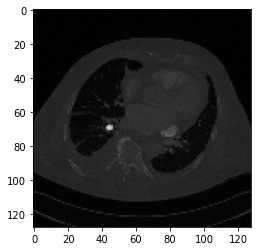

In [12]:
print(np.unique(i)),print(np.unique(l))
print(i.dtype , l.dtype)
print(i.shape , l.shape)

plt.imshow(i.permute(1,2,0),cmap="gray")
plt.imshow(l.permute(1,2,0),cmap="gray",alpha=0.6)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True , num_workers = num_gpus)
val_loader = DataLoader(val_dataset, batch_size=8,shuffle=True,num_workers = num_gpus)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True,num_workers = num_gpus)

In [14]:
from torch.nn.parallel import DataParallel
from cad_pe_segmentation.model_org import *
from torchsummary import summary

In [15]:
model = UNet(n_channels=1,n_classes=1)
model = DataParallel(model, device_ids=[0,1,2,3], dim=0)
model = model.to(device)
summary(model,(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
       double_conv-7         [-1, 64, 256, 256]               0
            inconv-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

In [16]:
#loss_fn = nn.BCELoss(reduction="mean")
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = DiceLoss(sigmoid = True)
#loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
dice = Dice(average='micro').to(device)
loss_fn , optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [17]:
from cad_pe_segmentation.train import *

In [25]:
epochs = 30
train(epochs, model, train_loader,val_loader)

  3%|▎         | 1/30 [07:16<3:30:49, 436.18s/it]

Epoch 1 | Train Loss: 0.00016 | Val Loss: 0.00029 |Dice Coefficient: 0.86791 | Val Dice Coefficient: 0.72105


  7%|▋         | 2/30 [14:32<3:23:30, 436.10s/it]

Epoch 2 | Train Loss: 0.00016 | Val Loss: 0.00029 |Dice Coefficient: 0.86833 | Val Dice Coefficient: 0.70258


 10%|█         | 3/30 [21:49<3:16:24, 436.47s/it]

Epoch 3 | Train Loss: 0.00016 | Val Loss: 0.00029 |Dice Coefficient: 0.86887 | Val Dice Coefficient: 0.71314


 13%|█▎        | 4/30 [29:05<3:09:03, 436.29s/it]

Epoch 4 | Train Loss: 0.00016 | Val Loss: 0.00029 |Dice Coefficient: 0.86936 | Val Dice Coefficient: 0.70750


 17%|█▋        | 5/30 [36:20<3:01:36, 435.87s/it]

Epoch 5 | Train Loss: 0.00016 | Val Loss: 0.00029 |Dice Coefficient: 0.87035 | Val Dice Coefficient: 0.71022


 20%|██        | 6/30 [43:34<2:54:10, 435.43s/it]

Epoch 6 | Train Loss: 0.00015 | Val Loss: 0.00029 |Dice Coefficient: 0.87173 | Val Dice Coefficient: 0.70984


 23%|██▎       | 7/30 [50:51<2:47:06, 435.93s/it]

Epoch 7 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87267 | Val Dice Coefficient: 0.71128


 27%|██▋       | 8/30 [58:07<2:39:46, 435.76s/it]

Epoch 8 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87343 | Val Dice Coefficient: 0.71063


 30%|███       | 9/30 [1:05:22<2:32:26, 435.54s/it]

Epoch 9 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87373 | Val Dice Coefficient: 0.71165


 33%|███▎      | 10/30 [1:12:41<2:25:34, 436.70s/it]

Epoch 10 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87454 | Val Dice Coefficient: 0.70961


 37%|███▋      | 11/30 [1:19:59<2:18:23, 437.02s/it]

Epoch 11 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87532 | Val Dice Coefficient: 0.70906


 40%|████      | 12/30 [1:27:11<2:10:40, 435.56s/it]

Epoch 12 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87563 | Val Dice Coefficient: 0.70986


 43%|████▎     | 13/30 [1:34:27<2:03:28, 435.77s/it]

Epoch 13 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87612 | Val Dice Coefficient: 0.70989


 47%|████▋     | 14/30 [1:41:42<1:56:06, 435.39s/it]

Epoch 14 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87649 | Val Dice Coefficient: 0.70945


 50%|█████     | 15/30 [1:48:55<1:48:39, 434.64s/it]

Epoch 15 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87695 | Val Dice Coefficient: 0.70890


 53%|█████▎    | 16/30 [1:56:09<1:41:23, 434.51s/it]

Epoch 16 | Train Loss: 0.00015 | Val Loss: 0.00030 |Dice Coefficient: 0.87723 | Val Dice Coefficient: 0.70793


 57%|█████▋    | 17/30 [2:03:22<1:34:03, 434.09s/it]

Epoch 17 | Train Loss: 0.00014 | Val Loss: 0.00030 |Dice Coefficient: 0.87744 | Val Dice Coefficient: 0.70827


 60%|██████    | 18/30 [2:10:38<1:26:57, 434.75s/it]

Epoch 18 | Train Loss: 0.00014 | Val Loss: 0.00030 |Dice Coefficient: 0.87799 | Val Dice Coefficient: 0.70832


 63%|██████▎   | 19/30 [2:17:55<1:19:49, 435.43s/it]

Epoch 19 | Train Loss: 0.00014 | Val Loss: 0.00030 |Dice Coefficient: 0.87823 | Val Dice Coefficient: 0.70859


 67%|██████▋   | 20/30 [2:25:08<1:12:25, 434.53s/it]

Epoch 20 | Train Loss: 0.00014 | Val Loss: 0.00030 |Dice Coefficient: 0.87884 | Val Dice Coefficient: 0.70901


 70%|███████   | 21/30 [2:32:22<1:05:10, 434.51s/it]

Epoch 21 | Train Loss: 0.00014 | Val Loss: 0.00030 |Dice Coefficient: 0.87909 | Val Dice Coefficient: 0.70908


 73%|███████▎  | 22/30 [2:39:36<57:54, 434.34s/it]  

Epoch 22 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.87912 | Val Dice Coefficient: 0.70910


 77%|███████▋  | 23/30 [2:46:52<50:42, 434.68s/it]

Epoch 23 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.87943 | Val Dice Coefficient: 0.70944


 80%|████████  | 24/30 [2:54:07<43:29, 434.85s/it]

Epoch 24 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.87963 | Val Dice Coefficient: 0.70986


 83%|████████▎ | 25/30 [3:01:20<36:11, 434.36s/it]

Epoch 25 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88003 | Val Dice Coefficient: 0.70999


 87%|████████▋ | 26/30 [3:08:36<28:58, 434.69s/it]

Epoch 26 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88045 | Val Dice Coefficient: 0.71084


 90%|█████████ | 27/30 [3:15:52<21:45, 435.17s/it]

Epoch 27 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88084 | Val Dice Coefficient: 0.71106


 93%|█████████▎| 28/30 [3:23:05<14:29, 434.64s/it]

Epoch 28 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88126 | Val Dice Coefficient: 0.71124


 97%|█████████▋| 29/30 [3:30:22<07:15, 435.26s/it]

Epoch 29 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88160 | Val Dice Coefficient: 0.71144


100%|██████████| 30/30 [3:37:38<00:00, 435.29s/it]

Epoch 30 | Train Loss: 0.00014 | Val Loss: 0.00031 |Dice Coefficient: 0.88197 | Val Dice Coefficient: 0.71124


In [28]:
def test():
    test_loss = 0
    test_dice_coefficient = []
    test_dice_loss = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            image, label = data
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            # calculate dice coefficient and dice loss
            #pred = (output > 0.5).float()
            label = label.to(torch.int64)
            testdice = dice(output, label)
            dice_loss = 1 - testdice

            test_loss += loss.item()
            test_dice_coefficient.append(testdice.item())
            test_dice_loss += dice_loss.item()

        # calculate average test loss, dice coefficient, and dice loss
        #print(len(test_dice_coefficient))
    test_loss /= len(test_loader)
    avg_test_dice_coefficient = sum(test_dice_coefficient)/len(test_dice_coefficient)
    test_dice_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.5f} | Dice Loss: {test_dice_loss:.5f} | Dice Coefficient: {avg_test_dice_coefficient:.5f}")


    
    
test()

Test Loss: 0.00030 | Dice Loss: 0.29569 | Dice Coefficient: 0.70431


0
1
2
3
4


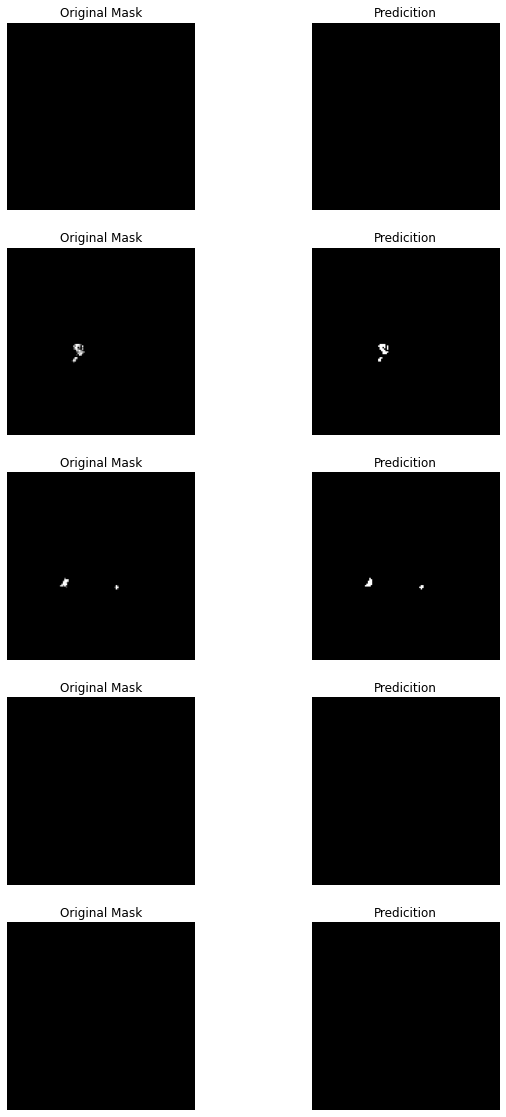

In [29]:
n_max_imgs = 5

plt.figure(figsize=(10, 20))
for n in range(n_max_imgs):
    model.eval()
    print(n)
    #print(len(test_dataset))
    x, t = val_dataset[n]
    x,t = x.to(device) , t.to(device)
    y = model(x.unsqueeze(0)) 
    y_label = (y>0).int().squeeze()
    
    #t = np.squeeze(t) 
    #print(torch.unique(y_label))
    t = t.cpu()
    
    z = y_label.cpu()
    
    plt.subplot(n_max_imgs, 2, 2*n+1)
    # plt.imshow(x.cpu().permute(1,2,0),cmap = "gray")
    plt.imshow(t.permute(1,2,0),cmap = "gray",alpha = 1)
    plt.title("Original Mask")
    plt.axis(False);
    plt.subplot(n_max_imgs, 2, 2*n+2)
    # plt.imshow(x.cpu().permute(1,2,0),cmap = "gray")
    plt.imshow(z,alpha = 1,cmap = "gray")
    plt.title("Predicition")
    plt.axis(False);
    # plt.savefig("overleafasu_mayo_results.png",dpi=300)
plt.show()